# Dataset 2: Ling-Spam Email Classification (Baseline vs Hyperparameter Optimization)

## Objective
The goal of this experiment is to evaluate spam detection performance on the Ling-Spam email corpus (folder-based dataset). We apply the same TF-IDF + Logistic Regression approach used in Dataset 1 and compare a baseline model against a hyperparameter-optimized version to analyze changes in accuracy and spam recall.

## Environment Setup
This section imports the required Python libraries for data handling, model training, evaluation, and visualization.

In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Dataset Extraction
The Ling-Spam corpus is provided as folders of email files. Each file contains one message. According to the dataset README, filenames starting with `spmsg` represent spam messages, while all other files represent legitimate (ham) messages. We load the raw version (`bare`) to keep preprocessing consistent.

In [2]:
# Extract the dataset archive (make sure lingspam_public.tar.gz is uploaded in /content)
!tar -xzf lingspam_public.tar.gz

# Quick check
!ls lingspam_public

bare  lemm  lemm_stop  readme.txt  stop


In [3]:
def load_lingspam_dataset(base_path):
    texts = []
    labels = []

    for part in os.listdir(base_path):
        part_path = os.path.join(base_path, part)
        if not os.path.isdir(part_path):
            continue

        for filename in os.listdir(part_path):
            file_path = os.path.join(part_path, filename)

            # Email files may have non-UTF8 characters
            try:
                with open(file_path, "r", encoding="latin-1") as f:
                    text = f.read()
            except:
                continue

            # Label rule from README: spmsg*.txt => spam, others => ham
            label = 1 if filename.startswith("spmsg") else 0

            texts.append(text)
            labels.append(label)

    return pd.DataFrame({"text": texts, "label": labels})

In [4]:
df2 = load_lingspam_dataset("/content/lingspam_public/bare")

df2.head(), df2["label"].value_counts(), df2.shape

(                                                text  label
 0  Subject: 8 . 859 , disc : punctuation\n\njohn ...      0
 1  Subject: e-gift certificate # 212-6587900 - 82...      1
 2  Subject: workshop on modality ( second call fo...      0
 3  Subject: linguistics association of great brit...      0
 4  Subject: language instinct\n\nisbn : 0 304 339...      0,
 label
 0    2412
 1     481
 Name: count, dtype: int64,
 (2893, 2))

## Train-Test Split
The dataset is split into training and testing sets using an 80/20 ratio. Stratification is applied to preserve the original class distribution and ensure fair evaluation.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df2["text"],
    df2["label"],
    test_size=0.2,
    random_state=42,
    stratify=df2["label"]
)

## Baseline Model
A TF-IDF vectorizer combined with Logistic Regression is used as the baseline model. This is the same baseline as Dataset 1, allowing a fair comparison across datasets with different formats (SMS vs email).

In [6]:
baseline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LogisticRegression(max_iter=1000))
])

baseline.fit(X_train, y_train)
pred = baseline.predict(X_test)

print("Dataset 2 Baseline accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

Dataset 2 Baseline accuracy: 0.9671848013816926
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       483
           1       1.00      0.80      0.89        96

    accuracy                           0.97       579
   macro avg       0.98      0.90      0.94       579
weighted avg       0.97      0.97      0.97       579

[[483   0]
 [ 19  77]]


### Baseline Results
The baseline model achieves strong accuracy on Ling-Spam. However, the confusion matrix typically shows that some spam emails are still missed (classified as ham). This motivates applying hyperparameter optimization to improve spam recall.

## Hyperparameter Optimization
RandomizedSearchCV is used to tune TF-IDF and Logistic Regression parameters. The goal is to improve spam recall while maintaining high overall accuracy, using the same tuning approach as Dataset 1.

In [7]:
param_dist = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2, 5],
    "tfidf__max_df": [0.8, 0.9, 1.0],
    "clf__C": [0.1, 1, 10],
    "clf__class_weight": [None, "balanced"]
}

search2 = RandomizedSearchCV(
    baseline,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search2.fit(X_train, y_train)

best_model_2 = search2.best_estimator_
pred_best_2 = best_model_2.predict(X_test)

print("Dataset 2 Best parameters:", search2.best_params_)
print("Dataset 2 Tuned accuracy:", accuracy_score(y_test, pred_best_2))
print(classification_report(y_test, pred_best_2))
print(confusion_matrix(y_test, pred_best_2))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Dataset 2 Best parameters: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 5, 'tfidf__max_df': 0.8, 'clf__class_weight': 'balanced', 'clf__C': 10}
Dataset 2 Tuned accuracy: 0.9930915371329879
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       483
           1       0.99      0.97      0.98        96

    accuracy                           0.99       579
   macro avg       0.99      0.98      0.99       579
weighted avg       0.99      0.99      0.99       579

[[482   1]
 [  3  93]]


### Tuned Model Results
Hyperparameter optimization improves performance compared to the baseline model, especially by increasing spam recall and reducing the number of spam emails that are misclassified as legitimate messages.

## Model Comparison
Baseline and tuned models are compared using accuracy and spam recall to visualize the improvement gained through tuning.

In [8]:
results_df_2 = pd.DataFrame({
    "Model": ["Baseline", "Tuned"],
    "Accuracy": [0.9672, 0.9931],
    "Spam Recall": [0.80, 0.9688]
})

results_df_2

,Model,Accuracy,Spam Recall
0,Baseline,0.9672,0.8000
1,Tuned,0.9931,0.9688


<Axes: title={'center': 'Dataset 2 (Ling-Spam): Baseline vs Tuned Performance'}, xlabel='Model'>

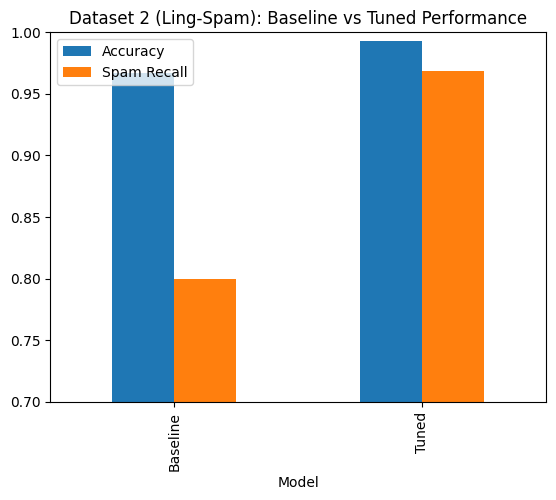

In [9]:
results_df_2.plot(
    x="Model",
    y=["Accuracy", "Spam Recall"],
    kind="bar",
    ylim=(0.7, 1.0),
    title="Dataset 2 (Ling-Spam): Baseline vs Tuned Performance"
)

## Dataset 2 Summary
The Ling-Spam dataset contains longer and more formal email messages compared to the SMS dataset. The baseline TF-IDF + Logistic Regression model performs well, and hyperparameter optimization further improves results by increasing spam recall and reducing missed spam emails. This shows that the tuning benefits generalize to a different data format and message length.